# DCGAN

- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks(https://arxiv.org/pdf/1511.06434.pdf)

![alt text](http://2.bp.blogspot.com/-oMyhHfxOqiE/WKF4KlVYWJI/AAAAAAAABRs/6BDIypy1hn0U8MGRFxfVaXOcQDO7vX1cQCK4B/s1600/dcgan-architecture.PNG)

### Deconvolution 

![transpose convolution](https://i.stack.imgur.com/YyCu2.gif)


### Transposed Convolution
![transpose convolution](https://cdn-images-1.medium.com/max/1200/1*Lpn4nag_KRMfGkx1k6bV-g.gif)

- output size 가 같다는 점만 공통점
- 패딩으로 0을 두른다
- 따라서 input에 패딩 사이즈, stride 정보가 필요하다.
- fractionally-strided convolutions이라고도 불린다

## 1. Import required libraries

In [5]:
# Code by GunhoChoi

import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
from torch.autograd import Variable
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

## 2. Hyperparameter setting

In [6]:
# Set Hyperparameters
# change num_gpu to the number of gpus you want to use

epoch = 50
batch_size = 512
learning_rate = 0.0002
num_gpus = 1

## 3. Data Setting

In [7]:
# Download Data

mnist_train = dset.MNIST("./", train=True, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                        ]),
                        target_transform=None,
                        download=True)

# Set Data Loader(input pipeline)

train_loader = torch.utils.data.DataLoader(dataset=mnist_train,batch_size=batch_size,shuffle=True,drop_last=True)

## 4. Generator

 Discriminator에서는 데이터의 차원이 줄어드는데, Generator는 반대로 차원을 확장시킨다.

In [19]:
# G 클래스 정의 
# 1. 총 네번의 Transposed Convolution 거친다. (pooling 대신 사용)
# 2. 마지막 단에 fclayer 쓰지않는다.
# 3. Batch Norm 사용
# 4. act func 으로 ReLU 사용 마지막 단에만 tanh쓴다.


# Generator receives random noise z and create 1x28x28 image
# we can name each layer using OrderedDict

class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        
        
        self.layer1 = nn.Sequential(
             nn.Linear(100,7*7*256),  # 길이 100짜리 노이즈(z)가 들어왔을때 7 by 7 by 256로 늘려줌 
             nn.BatchNorm1d(7*7*256), 
             nn.ReLU(),
        )

    # nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, output_padding)
    # -> 입력으로 들어오는 채널의 수, 만들어지는 결과값의 채널 수, 커널의 크기(Convolution 연산을 수행하는 필터의 크기) ,stride, padding

        self.layer2 = nn.Sequential(OrderedDict([
                        ('conv1', nn.ConvTranspose2d(256,128,3,2,1,1)), # Transposed Convolution1 256 -> 128
                        ('bn1', nn.BatchNorm2d(128)), 
                        ('relu1', nn.LeakyReLU()),
                        ('conv2', nn.ConvTranspose2d(128,64,3,1,1)), # Transposed Convolution2  # 128 -> 64 
                        ('bn2', nn.BatchNorm2d(64)),    
                        ('relu2', nn.LeakyReLU()),
            ]))
        
        
        
        self.layer3 = nn.Sequential(OrderedDict([
                        ('conv3',nn.ConvTranspose2d(64,16,3,1,1)), # Transposed Convolution3 # 64-> 16
                        ('bn3',nn.BatchNorm2d(16)),    
                        ('relu3',nn.LeakyReLU()),
                        ('conv4',nn.ConvTranspose2d(16,3,2,1,1)), # Transposed Convolution4  # 마지막 채널 RGB
                        ('relu4',nn.Tanh()) # 마지막 활성화 함수는 tanh
            ]))

    def forward(self,z):
        out = self.layer1(z)  
        out = out.view(batch_size//num_gpus,256,7,7) # 배치사이즈 고려하여 쪼갬
        out = self.layer2(out)
        out = self.layer3(out)
        return out # fake image 

## 5. Discriminator

일반적인 CNN과 비슷하나 활성화함수로 LeakyReLU를 사용한다는 것에 주의

In [9]:
# Discriminator receives 1x28x28 image and returns a float number 0~1
# we can name each layer using OrderedDict

# D 클래스 정의
# act func 으로 LeakyReLU 사용


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.layer1 = nn.Sequential(OrderedDict([
                        ('conv1',nn.Conv2d(1,8,3,padding=1)),   # batch x 16 x 28 x 28
                        #('bn1',nn.BatchNorm2d(8)),    
                        ('relu1',nn.LeakyReLU()),               # LeakyReLU
                        ('conv2',nn.Conv2d(8,16,3,padding=1)),  # batch x 32 x 28 x 28
                        ('bn2',nn.BatchNorm2d(16)),    
                        ('relu2',nn.LeakyReLU()),                # LeakyReLU
                        ('max1',nn.MaxPool2d(2,2))   # batch x 32 x 14 x 14
        ]))
        self.layer2 = nn.Sequential(OrderedDict([
                        ('conv3',nn.Conv2d(16,32,3,padding=1)),  # batch x 64 x 14 x 14
                        ('bn3',nn.BatchNorm2d(32)),
                        ('relu3',nn.LeakyReLU()),                # LeakyReLU
                        ('max2',nn.MaxPool2d(2,2)),
                        ('conv4',nn.Conv2d(32,64,3,padding=1)),  # batch x 128 x 7 x 7
                        ('bn4',nn.BatchNorm2d(64)),
                        ('relu4',nn.LeakyReLU())                  # LeakyReLU
        ]))
        self.fc = nn.Sequential(
                        nn.Linear(64*7*7,1), # 64*7*7 차원을 받아서 마지막은 1
                        nn.Sigmoid()  # 0~1 값을 가짐
        )

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size//num_gpus, -1)
        out = self.fc(out)
        return out # 0~1 score 

## 6. Put instances on Multi-gpu

In [10]:
# Put class objects on Multiple GPUs using 
# torch.nn.DataParallel(module, device_ids=None, output_device=None, dim=0)
# device_ids: default all devices / output_device: default device 0 
# along with .cuda()

generator = nn.DataParallel(Generator()) #.cuda()
discriminator = nn.DataParallel(Discriminator()) # .cuda()

## 7. Check layers

In [11]:
# Get parameter list by using class.state_dict().keys()

gen_params = generator.state_dict().keys()
dis_params = discriminator.state_dict().keys()

for i in gen_params:
    print(i)

module.layer1.0.weight
module.layer1.0.bias
module.layer1.1.weight
module.layer1.1.bias
module.layer1.1.running_mean
module.layer1.1.running_var
module.layer2.conv1.weight
module.layer2.conv1.bias
module.layer2.bn1.weight
module.layer2.bn1.bias
module.layer2.bn1.running_mean
module.layer2.bn1.running_var
module.layer2.conv2.weight
module.layer2.conv2.bias
module.layer2.bn2.weight
module.layer2.bn2.bias
module.layer2.bn2.running_mean
module.layer2.bn2.running_var
module.layer3.conv3.weight
module.layer3.conv3.bias
module.layer3.bn3.weight
module.layer3.bn3.bias
module.layer3.bn3.running_mean
module.layer3.bn3.running_var
module.layer3.conv4.weight
module.layer3.conv4.bias


## 8. Set Loss function & Optimizer

In [12]:
# loss function, optimizers, and labels for training

# loss function -> MSE
loss_func = nn.MSELoss()

# G, D 각각 adam 최적화 기법 적용
gen_optim = torch.optim.Adam(generator.parameters(), lr= 5*learning_rate, betas=(0.5,0.999))
dis_optim = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5,0.999))

ones_label = Variable(torch.ones(batch_size,1)) #.cuda()
zeros_label = Variable(torch.zeros(batch_size,1))#.cuda()

def image_check(gen_fake):
    img = gen_fake.data.numpy()
    for i in range(10):
        plt.imshow(img[i][0],cmap='gray')
        plt.show()

## 9. Restore Model

In [13]:
# model restore if any

try:
    generator, discriminator = torch.load('./model/dcgan.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


--------model restored--------



## 10. Train Model

/Users/smlee/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:10: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  # Remove the CWD from sys.path while we load stuff.
/Users/smlee/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


(tensor(0.2020), tensor(0.6730))
0th iteration gen_loss: 0.202042475343 dis_loss: 0.67297410965


/Users/smlee/anaconda/lib/python2.7/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/smlee/anaconda/lib/python2.7/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


(tensor(0.3101), tensor(0.4568))
0th iteration gen_loss: 0.310104042292 dis_loss: 0.456804841757
(tensor(0.6288), tensor(0.1182))
0th iteration gen_loss: 0.628771543503 dis_loss: 0.118207171559


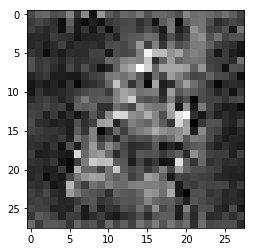

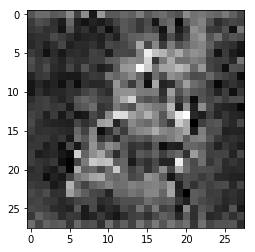

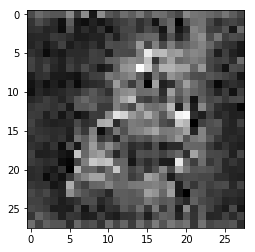

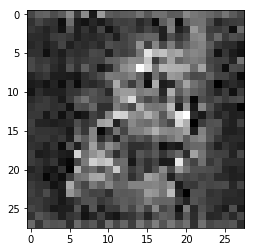

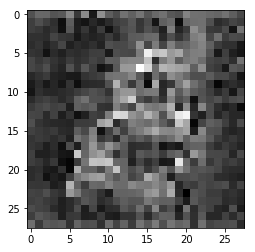

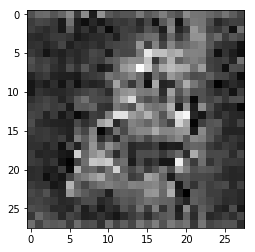

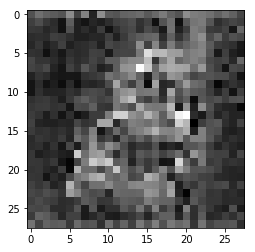

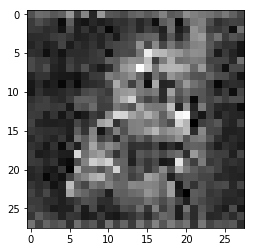

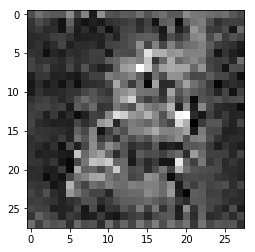

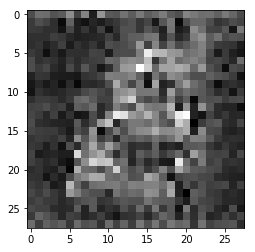

(tensor(0.6314), tensor(0.1281))
1th iteration gen_loss: 0.631391704082 dis_loss: 0.128095984459
(tensor(0.7765), tensor(1.00000e-02 *
       4.1136))
1th iteration gen_loss: 0.776478588581 dis_loss: 0.0411363206804
(tensor(0.8097), tensor(1.00000e-02 *
       4.7956))
1th iteration gen_loss: 0.809721469879 dis_loss: 0.0479562729597


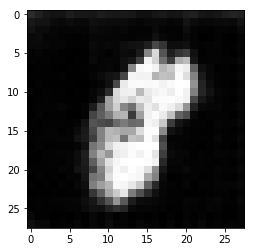

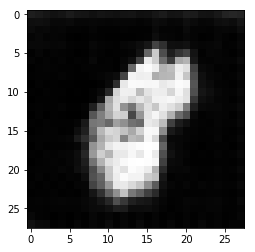

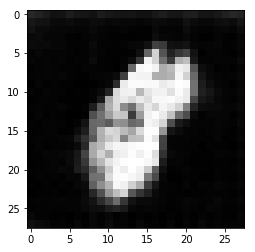

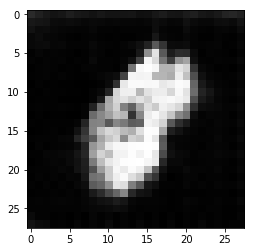

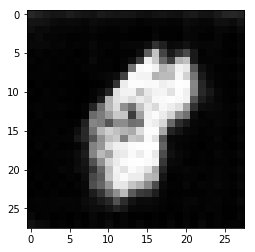

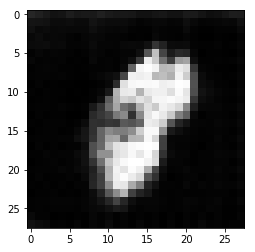

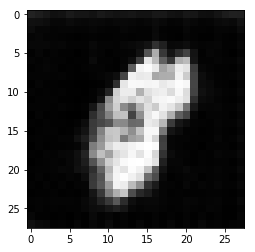

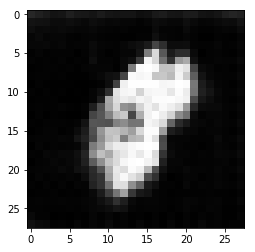

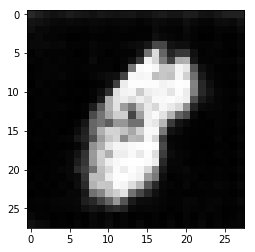

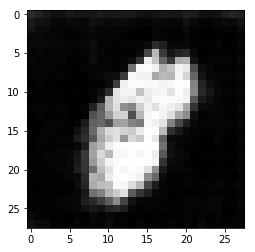

(tensor(0.5308), tensor(0.3476))
2th iteration gen_loss: 0.530805110931 dis_loss: 0.347630470991
(tensor(0.2783), tensor(0.3425))
2th iteration gen_loss: 0.278320431709 dis_loss: 0.34245878458
(tensor(0.5698), tensor(0.1850))
2th iteration gen_loss: 0.569754064083 dis_loss: 0.185003086925


In [ ]:
# train

for i in range(epoch):
    for j,(image,label) in enumerate(train_loader):
        image = Variable(image) #.cuda()
        
        ####### generator ########
        gen_optim.zero_grad()
        
        # 노이즈 z 를 배치사이즈만큼 생성  
        z = Variable(init.normal(torch.Tensor(batch_size,100),mean=0,std=0.1)) #.cuda()

        # feed foward
        gen_fake = generator.forward(z) # fake image 
        dis_fake = discriminator.forward(gen_fake) # fake image 에 대한 score 0~1
        
        gen_loss = torch.sum(loss_func(dis_fake,ones_label)) # fake classified as real (MSE)
        
        # backprob 진행 
        gen_loss.backward()
        gen_optim.step()
    
        ####### discriminator ######
        dis_optim.zero_grad()
        
        # noise z 생성 
        z = Variable(init.normal(torch.Tensor(batch_size,100),mean=0,std=0.1)) #.cuda()
         
        gen_fake = generator.forward(z)  # z로 부터, fake image 생성
        dis_fake = discriminator.forward(gen_fake) # fake image 에 대한 score 값 계산 
        
        dis_real = discriminator.forward(image) #  real image 에 대한 D(x_real) 값 0~1
 
        dis_loss = torch.sum(loss_func(dis_fake,zeros_label)) + torch.sum(loss_func(dis_real,ones_label))
        
        dis_loss.backward()
        dis_optim.step()
    
        # model save
        if j % 50 == 0:
            print(gen_loss,dis_loss)
            torch.save([generator,discriminator],'./model/dcgan.pkl')

            print("{}th iteration gen_loss: {} dis_loss: {}".format(i,gen_loss.data,dis_loss.data))
            v_utils.save_image(gen_fake.data[0:25],"./result/gen_{}_{}.png".format(i,j), nrow=5)
            
    image_check(gen_fake.cpu())